**Predicting credit card default**

Time period : Apr to Sept 2005

columns of importance 

Repayment status 
Pay_0 - Sept
Pay_2 - Aug...

Bill statement
Bill_Amt1 - Amt of bill statement in Sept
Bill_Amt2 - Amt of bill statement in Aug...

Previous payment
Pay_Amt1 - Amt of previous payment in Sept
Pay_Amt2 - Amt of previous paymnet in Aug...

In [1]:
# importing the necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas_profiling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report, average_precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.tree import export_graphviz

Using TensorFlow backend.


In [2]:
df = pd.read_excel('/Users/mahimakaushiva/Desktop/Personal_Projects/credit_card_default/default of credit card clients.xls')
df.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0         0         0         0                           1  
1      1000         0      2000                           1  
2      1000      1000      5000                           0  
3      1100      1069      1000                           0  
4      9000       689       679                           0  

[5 rows x 25 columns]

In [3]:
pandas_profiling.ProfileReport(df)

**EDA**

In [4]:
df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default_payment_next_month    0
dtype: int64

In [5]:
# dropping Bill Amt 2,3,4,5,6 as they are highly correlated with Bill Amt 1

df = df.drop(columns = ['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'], axis=1)
df.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  PAY_6  BILL_AMT1  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  \
0     -2     -2       3913         0       689         0         0         0   
1      0      2       2682         0      1000      1000      1000         0   
2      0      0      29239      1518      1500      1000      1000      1000   
3      0      0      46990      2000      2019      1200      1100      1069   
4      0      0       8617      2000     36681     10000      9000       689   

   PAY_AMT6  default_payment_next_month  
0         0                           1  
1      2000                           1  
2      5000                           0  
3      1000                           0  
4       679                           0

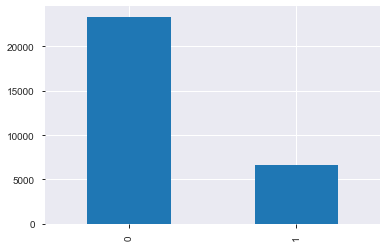

In [6]:
# plotting the distribution of default vs no default customers next month
# 0 - no default and 1 - default

df['default_payment_next_month'].value_counts().plot.bar()

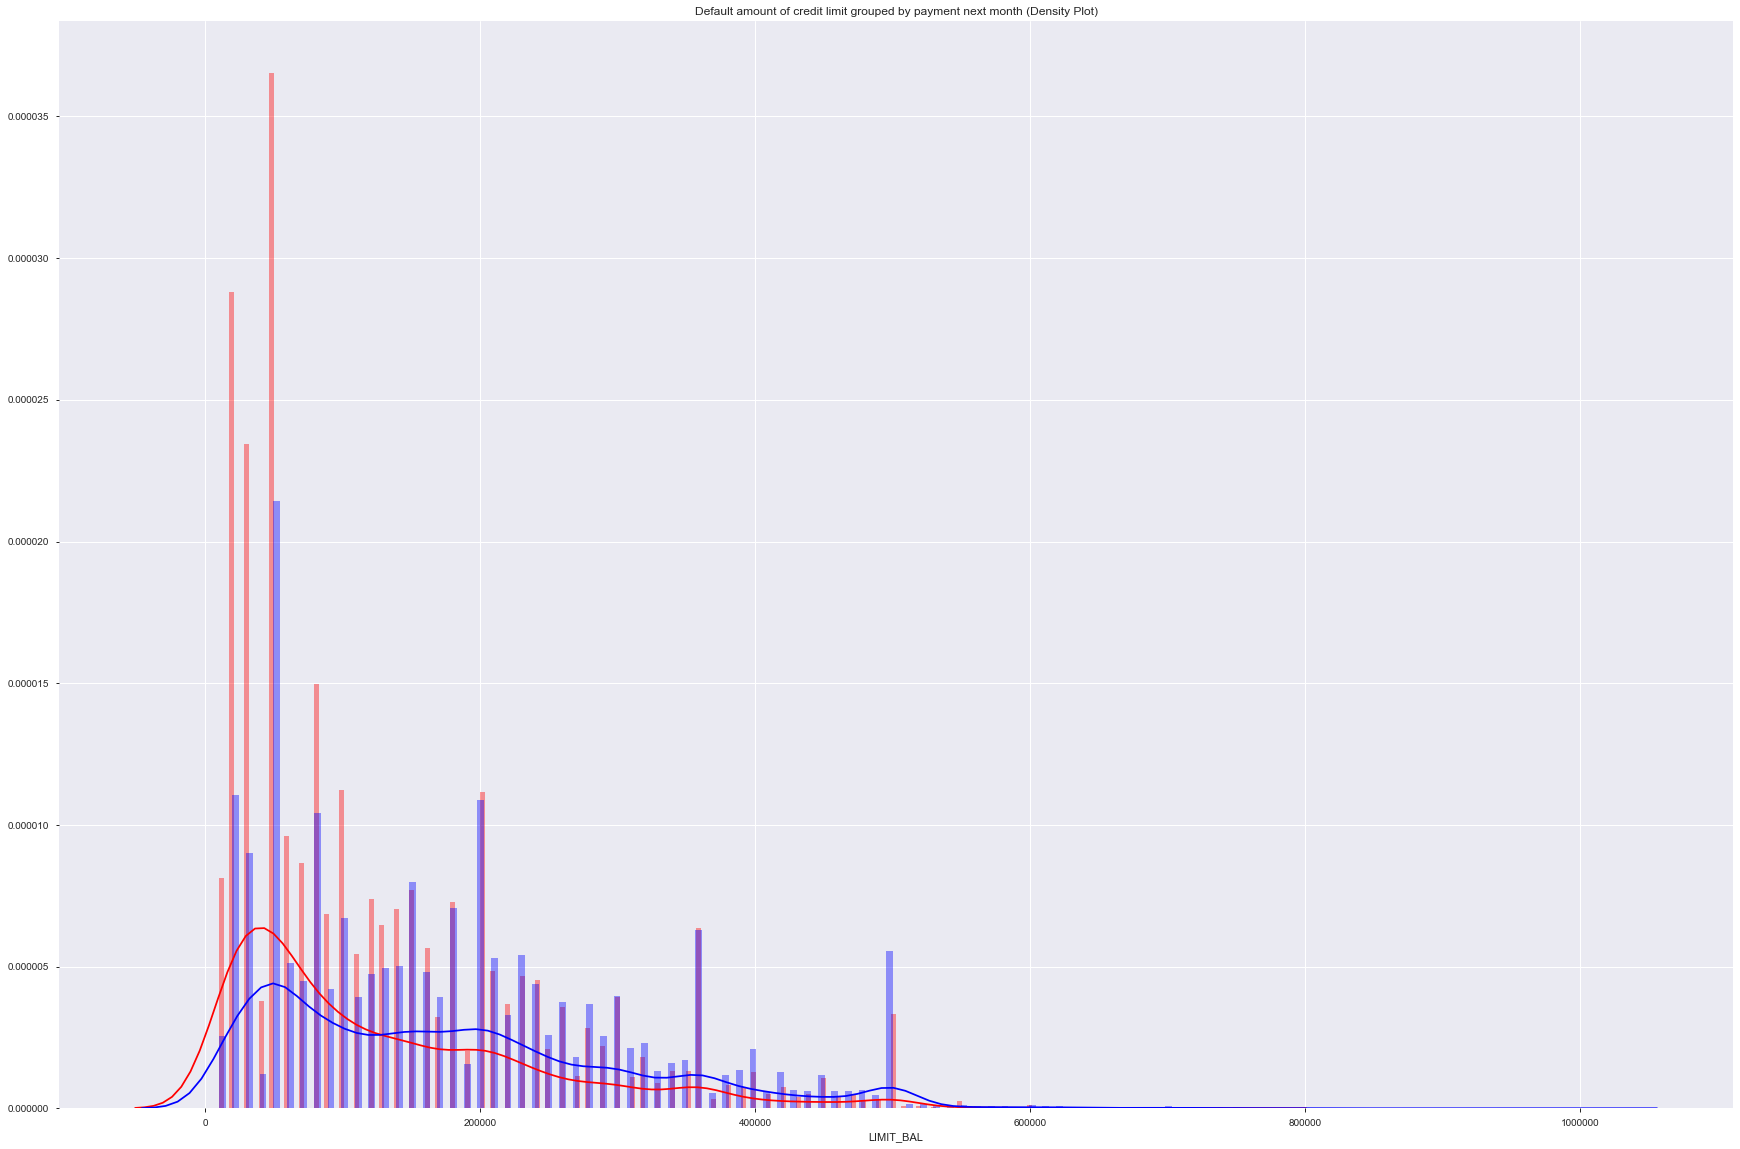

In [7]:
# calculating the amount of credit limit grouped by default next month

class_0 = df.loc[df['default_payment_next_month'] == 0]['LIMIT_BAL']
class_1 = df.loc[df['default_payment_next_month'] == 1]['LIMIT_BAL']

plt.figure(figsize = (30,20))
plt.title('Default amount of credit limit grouped by payment next month (Density Plot)')

sns.set_color_codes('colorblind')
sns.distplot(class_1, kde= True, bins = 200, color = 'red')
sns.distplot(class_0, kde= True, bins = 200, color = 'blue')

In [8]:
# defining our predictor and target variables

X = df.drop(['default_payment_next_month'], axis = 1)
y = df['default_payment_next_month']

In [9]:
# normalising the values to make them comparable

X = X.apply(lambda x: (x - x.min())/ (x.max() - x.min()), axis = 0)
X.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE       AGE  PAY_0  PAY_2  \
0  0.000000   0.010101  1.0   0.333333  0.333333  0.051724    0.4    0.4   
1  0.000033   0.111111  1.0   0.333333  0.666667  0.086207    0.1    0.4   
2  0.000067   0.080808  1.0   0.333333  0.666667  0.224138    0.2    0.2   
3  0.000100   0.040404  1.0   0.333333  0.333333  0.275862    0.2    0.2   
4  0.000133   0.040404  0.0   0.333333  0.333333  0.620690    0.1    0.2   

   PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0    0.1    0.1    0.0    0.0   0.149982  0.000000  0.000409  0.000000   
1    0.2    0.2    0.2    0.4   0.148892  0.000000  0.000594  0.001116   
2    0.2    0.2    0.2    0.2   0.172392  0.001738  0.000891  0.001116   
3    0.2    0.2    0.2    0.2   0.188100  0.002290  0.001199  0.001339   
4    0.1    0.2    0.2    0.2   0.154144  0.002290  0.021779  0.011160   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  
0  0.000000  0.000000  0.000000  
1  0.001610  0.000000  0.003783  
2  0.001610  0.002345  0.009458  
3  0.001771  0.002506  0.001892  
4  0.014493  0.001615  0.001284

In [10]:
# creating a new feature of bill amount / limit balance

df['dependence'] = df['BILL_AMT1'] / df['LIMIT_BAL'] * 100
df['dependence']

0        19.565000
1         2.235000
2        32.487778
3        93.980000
4        17.234000
           ...    
29995    85.885455
29996     1.122000
29997    11.883333
29998    -2.056250
29999    95.858000
Name: dependence, Length: 30000, dtype: float64

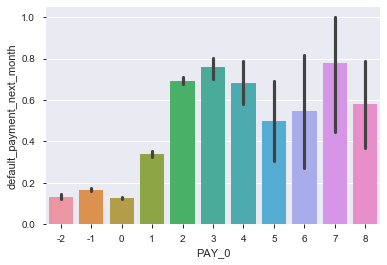

In [11]:
ax = sns.barplot(x = 'PAY_0', y = 'default_payment_next_month', data = df)

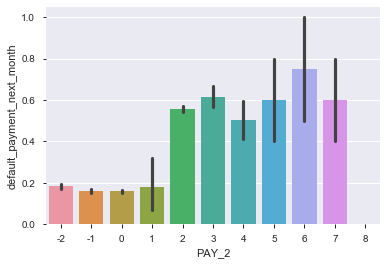

In [12]:
ax = sns.barplot(x = 'PAY_2', y = 'default_payment_next_month', data = df)

In [13]:
default = df.loc[df['default_payment_next_month'] == 1]
pd.set_option('display.max_columns', 999)
default.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0    1      20000    2          2         1   24      2      2     -1     -1   
1    2     120000    2          2         2   26     -1      2      0      0   
13  14      70000    1          2         2   30      1      2      2      0   
16  17      20000    1          1         2   24      0      0      2      2   
21  22     120000    2          2         1   39     -1     -1     -1     -1   

    PAY_5  PAY_6  BILL_AMT1  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  \
0      -2     -2       3913         0       689         0         0         0   
1       0      2       2682         0      1000      1000      1000         0   
13      0      2      65802      3200         0      3000      3000      1500   
16      2      2      15376      3200         0      1500         0      1650   
21     -1     -1        316       316       316         0       632       316   

    PAY_AMT6  default_payment_next_month  dependence  
0          0                           1   19.565000  
1       2000                           1    2.235000  
13         0                           1   94.002857  
16         0                           1   76.880000  
21         0                           1    0.263333

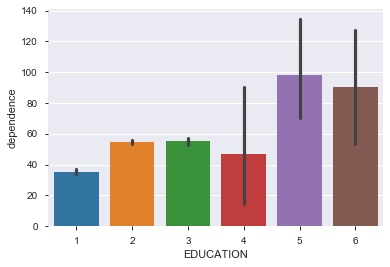

In [14]:
ax = sns.barplot(x = 'EDUCATION', y = 'dependence', data = default)

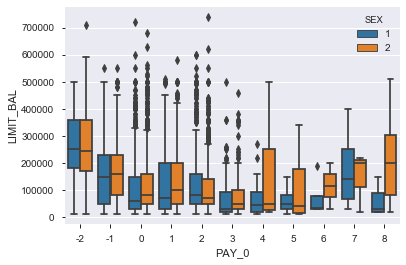

In [15]:
ax = sns.boxplot(x = 'PAY_0', y = 'LIMIT_BAL', hue = 'SEX', data = default)

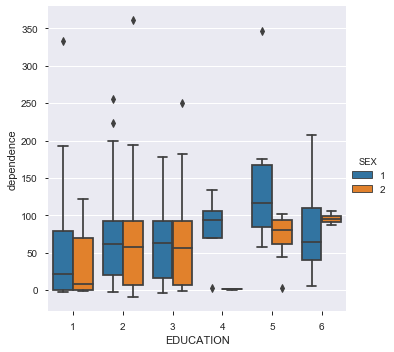

In [16]:
sns.catplot(x ='EDUCATION', y ='dependence', hue='SEX', kind='box', data= default)

In [17]:
def boxplot_variation(feature1, feature2, feature3):
    fig, ax1 = plt.subplots(ncols = 1, figsize= (12, 10))
    s = sns.boxplot(ax = ax1, x = feature1, y = feature2, hue = feature3,
                    data = df)
    s.set_xticklabels(s.get_xticklabels(), rotation=90)
    plt.show();

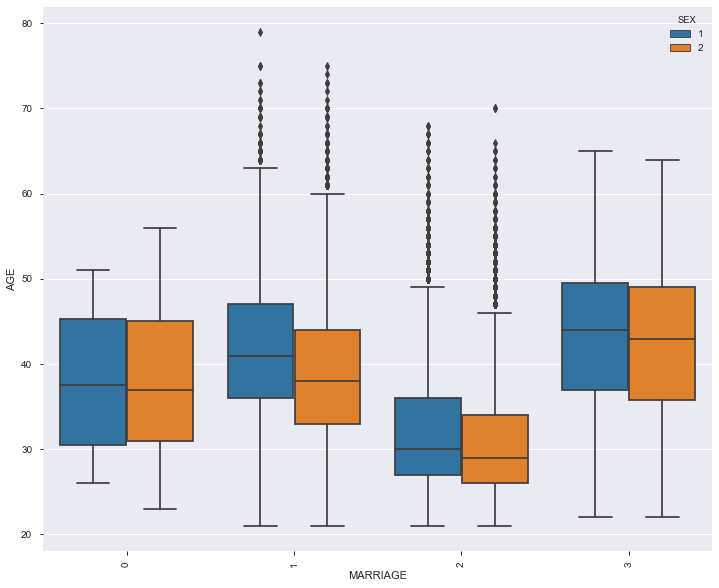

In [18]:
boxplot_variation('MARRIAGE', 'AGE', 'SEX')

boxplot_variation('MARRIAGE', 'LIMIT_BAL', 'EDUCATION')

**Model Building**

# steps to be followed

1. split data into train and test 
2. create a list of classifiers
3. create parameters for each classifier and let the algorithm decide which is the best parameter providing the best score
4. create a pipeline from step 1 and 2
5. use gridsearch to tune the parameters for each model
6. plot roc, auc, confusion matrix and learning curves to check for mean test and train accuracy

In [28]:
# splitting into train and test sets using an 80-20 split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [29]:
# since our classes are quite imbalanced, i.e. we have many more non-defaulters than defaulters, we will resample to balance the two
# applying SMOTE to our data and checking the class counts

X_resampled, y_resampled = SMOTE().fit_resample(X,y)
print(sorted(Counter(y_resampled).items()))

[(0, 23364), (1, 23364)]


** Decision Tree Classifier **

In [30]:
# creating an instance of a decision tree classifier with random state = 10 for reproducibility
# instantiate and fit the training data to the classifier

tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=10)

In [31]:
# train the Decision Tree Classifier

tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=10, splitter='best')

In [32]:
# predicting response for the test dataset

predict_proba = tree_clf.predict(X_test)
predict_proba

array([0, 0, 0, ..., 0, 0, 0])

In [33]:
# checking feature importance

tree_clf.feature_importances_

array([0.00671374, 0.03376274, 0.00115263, 0.00589017, 0.        ,
       0.00215497, 0.63480685, 0.15397095, 0.00911194, 0.01160078,
       0.01790041, 0.00994161, 0.03101155, 0.00120856, 0.00286488,
       0.06881155, 0.00565341, 0.        , 0.00344328])

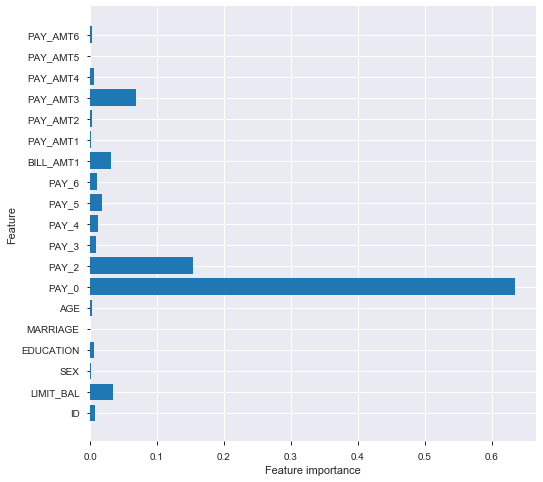

In [34]:
# visualising the features

def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align= 'center')
    plt.yticks(np.arange(n_features), X_train.columns.values)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    
plot_feature_importances(tree_clf)

In [35]:
# creating a classification report

print(classification_report(y_test, predict_proba))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.67      0.33      0.45      1313

    accuracy                           0.82      6000
   macro avg       0.75      0.64      0.67      6000
weighted avg       0.80      0.82      0.79      6000



In [36]:
# create and print a confusion matrix

print('\nConfusion Matrix')
print('------------------')
pd.crosstab(y_test, predict_proba, rownames = ['True'], colnames = ['Predicted'], margins = True)


Confusion Matrix
------------------


Predicted     0    1   All
True                      
0          4474  213  4687
1           874  439  1313
All        5348  652  6000

In [37]:
# checking predictive performance 

acc = accuracy_score(y_test, predict_proba)*100
print('Accuracy is :{0}'.format(acc))


Accuracy is :81.88333333333333


In [38]:
# checking auc for predictions

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predict_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))


AUC is :0.64


** Random Forest Classifier **

In [39]:
# using Gini as the validation coefficient. Number of estimators is set to 100 and number of parallel jobs to 4
# initializing the Random Forest Classifier

clf = RandomForestClassifier(n_jobs = None, random_state = None, criterion = 'gini', 
                             n_estimators = 100, verbose = False)

In [41]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state= None, shuffle=True )

In [43]:
clf.fit(X_train, y_train.values)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=False, warm_start=False)

**Ada Boost Classifier**

In [49]:
clf = AdaBoostClassifier(random_state=None,algorithm='SAMME.R', learning_rate=0.8, n_estimators=100)

In [50]:
clf.fit(X_train, y_train.values)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.8,
                   n_estimators=100, random_state=None)

In [53]:
# predicting the target values

preds = clf.predict(val_df(X_train))

TypeError: 'DataFrame' object is not callable